In [1]:
import numpy as np
from typing import List
import os
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Subset
exec(open("./lib_RMD_v2.py").read())
# from lib_FrogsCNN import *
momentum = 0.5
log_interval = 50

random_seed = 1
torch.backends.cudnn.enabled = False


class CustomTensorDataset(torch.utils.data.TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform
def dataloader_Frogs(int_ood = 3, batch_size_train = 15, batch_size_test = 15, random_seed=112892):
    """
    This function prepares the dataloader for the frogs dataset. 
    The int_ood is the index of the clade that is treated as OOD, choose 0-3 here
    The batch_size_train and batch_size_test are the batch sizes for training and testing respectively. 
    The random_seed is used for reproducibility.
    """
    torch.manual_seed(random_seed)
    # train_loader = torch.utils.data.DataLoader(train_dataset,
    # batch_size=batch_size_train, shuffle=True)
    vec_total = list(range(4))
    vec_total.pop(int_ood)
    dic_total = {vec_total[i]:i for i in range(3)}
    s = pd.Series(data=dic_total.values(), index=dic_total.keys())

    transform_image = torchvision.transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize([512, 512]),
    # transforms.RandomRotation(degrees=90),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
    ])
    ## need to subset: only use 4,5,8,12
    train_dataset = torchvision.datasets.ImageFolder("./filled_images/")
    vec_CV_clades = ("Clade4", "Clade5", "Clade8", "Clade12") ## we only use 4,5,8,12
    dict_CV_clades2trainidx = {} ### this mapes clade name too the corresponding label, which is used in the training dataset
    for i_clade in range(4):
        dict_CV_clades2trainidx[train_dataset.class_to_idx[vec_CV_clades[i_clade]]] = i_clade
    vec_CV_idx = []
    for i_clade in vec_CV_clades:
        vec_CV_idx.append(train_dataset.class_to_idx[i_clade])

    train_dataset = torchvision.datasets.ImageFolder("./filled_images/")
    idx = [i for i in range(len(train_dataset)) if train_dataset.imgs[i][1] in vec_CV_idx]
    CV_subset_train_dataset = Subset(train_dataset, idx)

    ## CUDA only accepts lablels 0,1,2,3, so we need to reassign the labels
    new_labels = []
    for i in range(len(CV_subset_train_dataset)):
        old_label = CV_subset_train_dataset[i][1]
        new_label = dict_CV_clades2trainidx[old_label]
        new_labels.append(new_label)
    CV_subset_train_dataset.dataset.targets = np.array(new_labels)
    
    vec_total = list(range(4))
    vec_total.pop(int_ood)
    dic_total = {vec_total[i]:i for i in range(3)}
    s = pd.Series(data=dic_total.values(), index=dic_total.keys())

    mat_train_dataset = np.empty(shape=(0,3,512,512))
    vec_train_labels=np.empty(shape=0)
    for _,data in enumerate(CV_subset_train_dataset):
        mat_train_dataset = np.vstack((mat_train_dataset,transform_image(data[0]).reshape(1,3,512,512)))
        vec_train_labels = np.append(vec_train_labels,dict_CV_clades2trainidx[data[1]])

    vec_train_id_idx = np.isin(vec_train_labels,int_ood,invert=True)

    mat_train_dataset_id = mat_train_dataset[vec_train_id_idx,:]
    mat_train_dataset_ood = mat_train_dataset[np.logical_not(vec_train_id_idx),:]
    ## assign the ID labels to 0,1,2, which is used in the training dataset
    vec_train_labels_id = np.array(s[vec_train_labels[vec_train_id_idx]])
    ## assign the OOD labels to 3, which is not used in the training dataset
    vec_train_labels_ood = np.array([3 for i in range(np.logical_not(vec_train_id_idx).sum())])
    transform_image_v2 = torchvision.transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize([512, 512]),
        # transforms.RandomRotation(degrees=90),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
        ])

    train_dataset_id = CustomTensorDataset((torch.Tensor(mat_train_dataset_id), torch.Tensor(vec_train_labels_id))
        , transform=transform_image_v2)
    train_dataset_ood = CustomTensorDataset((torch.Tensor(mat_train_dataset_ood), torch.Tensor(vec_train_labels_ood))
        , transform=transform_image_v2)

    train_loader_id = torch.utils.data.DataLoader(train_dataset_id,
        batch_size=batch_size_train, shuffle=True)
    train_loader_ood = torch.utils.data.DataLoader(train_dataset_ood,
        batch_size=batch_size_train, shuffle=True)

    print("train_loader_id, train_loader_ood")
    return train_loader_id, train_loader_ood,dic_total,train_dataset.class_to_idx


In [2]:

# %load model.py
## define model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 4, kernel_size=3)
        self.conv3_bn = nn.BatchNorm2d(4)

        self.fc1 = nn.Linear(15376, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc2_bn = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.fc3_bn = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        x = self.conv1_bn(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        x = self.conv2_bn(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)
        x = self.conv3_bn(x)


        x = x.view(-1, 15376)
        x = (self.fc1(x))
        x = F.dropout(x, p= 0.8,training=self.training)
        x = self.fc1_bn(x)

        x = (self.fc2(x))
        x = F.dropout(x, p= 0.8,training=self.training)
        x = self.fc2_bn(x)

        x = (self.fc3(x))
        x = F.dropout(x, p= 0.8,training=self.training)
        x = self.fc3_bn(x)

        x = (self.fc4(x))
        return x
    
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader_id):
        optimizer.zero_grad()
        data = data.view(data.shape[0],-1,512,512)
        data = data.cuda()
        # target = target.argmax(axis = 1).view(-1,1)
        target = target.cuda()
        output = network(data)
        loss = F.cross_entropy((output), target.long())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_id.dataset),
                100. * batch_idx / len(train_loader_id), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*16) + ((epoch-1)*len(train_loader_id.dataset)))
        data.cpu()
        target.cpu()

class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

In [3]:
train_loader_id, train_loader_ood,dic_total,cls2idx = dataloader_Frogs(int_ood=1 ,batch_size_train=18)

train_loader_id, train_loader_ood


In [4]:
n_epochs = 400
learning_rate = 0.001

In [5]:
vec_auc=[]
ii=0

train_loader_id, train_loader_ood,dic_total,cls2idx = dataloader_Frogs(int_ood=2 ,batch_size_train=18)

network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)#,
                    #   momentum=momentum)
network.cuda()
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader_id.dataset) for i in range(n_epochs + 1)]


network.cuda()

for epoch in range(1, n_epochs + 1):
    train(epoch)

train_loader_id, train_loader_ood
Train Epoch: 1 [0/116 (0%)]	Loss: 1.007275
Train Epoch: 2 [0/116 (0%)]	Loss: 1.145173
Train Epoch: 3 [0/116 (0%)]	Loss: 0.959450
Train Epoch: 4 [0/116 (0%)]	Loss: 0.956059
Train Epoch: 5 [0/116 (0%)]	Loss: 1.150880
Train Epoch: 6 [0/116 (0%)]	Loss: 1.195232
Train Epoch: 7 [0/116 (0%)]	Loss: 1.155985
Train Epoch: 8 [0/116 (0%)]	Loss: 1.100327
Train Epoch: 9 [0/116 (0%)]	Loss: 1.202833
Train Epoch: 10 [0/116 (0%)]	Loss: 1.027065
Train Epoch: 11 [0/116 (0%)]	Loss: 1.121147
Train Epoch: 12 [0/116 (0%)]	Loss: 1.072320
Train Epoch: 13 [0/116 (0%)]	Loss: 1.050098
Train Epoch: 14 [0/116 (0%)]	Loss: 1.245646
Train Epoch: 15 [0/116 (0%)]	Loss: 1.039046
Train Epoch: 16 [0/116 (0%)]	Loss: 0.916310
Train Epoch: 17 [0/116 (0%)]	Loss: 1.170122
Train Epoch: 18 [0/116 (0%)]	Loss: 1.037596
Train Epoch: 19 [0/116 (0%)]	Loss: 1.307140
Train Epoch: 20 [0/116 (0%)]	Loss: 1.009441
Train Epoch: 21 [0/116 (0%)]	Loss: 1.148020
Train Epoch: 22 [0/116 (0%)]	Loss: 1.256539
Train E

In [7]:
pre_label = np.empty(0)
true_label = np.empty(0)
network.cuda()
network.eval()
for batch_idx, (data, target) in enumerate(train_loader_id):
    true_label = np.append(true_label, target)
    out = network(data.cuda())
    pre_label = np.append(pre_label, np.exp(out.cpu().detach().numpy()).argmax(axis = 1))
from sklearn.metrics import confusion_matrix
mat_conf = confusion_matrix(true_label, pre_label)
mat_conf

array([[44,  0,  0],
       [ 0, 22,  0],
       [ 0,  0, 50]], dtype=int64)

In [8]:
hookF = [Hook(layer[1]) for layer in list(network._modules.items())]

train_id_lay128=np.array([]).reshape(0,128)
train_id_lay64=np.array([]).reshape(0,64)
train_id_lay3=np.array([]).reshape(0,3)
true_target = np.array([]).reshape(-1)
for batch_idx, (data, target) in enumerate(train_loader_id):
    out=network(data.cuda())
    train_id_lay128 = np.vstack([train_id_lay128,hookF[8].output.detach().cpu().numpy()])
    train_id_lay64 = np.vstack([train_id_lay64,hookF[10].output.detach().cpu().numpy()])
    train_id_lay3 = np.vstack([train_id_lay3,hookF[12].output.detach().cpu().numpy()])
    true_target = np.concatenate((true_target, target))

df_train_id_128 = pd.DataFrame(train_id_lay128, columns=["lay128_"+str(i) for i in range(128)])
df_train_id_128['dsource'] = "train_id"
df_train_id_128['true_lab']=true_target

df_train_id_64 = pd.DataFrame(train_id_lay64, columns=["lay64_"+str(i) for i in range(64)])
df_train_id_64['dsource'] = "train_id"
df_train_id_64['true_lab']=true_target

df_train_id_3 = pd.DataFrame(train_id_lay3, columns=["lay3_"+str(i) for i in range(3)])
df_train_id_3['dsource'] = "train_id"
df_train_id_3['true_lab']=true_target

train_ood_lay128=np.array([]).reshape(0,128)
train_ood_lay64=np.array([]).reshape(0,64)
train_ood_lay3=np.array([]).reshape(0,3)
for batch_idx, (data, target) in enumerate(train_loader_ood):
    out=network(data.cuda())
    train_ood_lay128 = np.vstack([train_ood_lay128,hookF[8].output.detach().cpu().numpy()])
    train_ood_lay64 = np.vstack([train_ood_lay64,hookF[10].output.detach().cpu().numpy()])
    train_ood_lay3 = np.vstack([train_ood_lay3,hookF[12].output.detach().cpu().numpy()])


df_train_ood_128 = pd.DataFrame(train_ood_lay128, columns=["lay128_"+str(i) for i in range(128)])
df_train_ood_128['dsource'] = "ood"
df_train_ood_128['true_lab']=-1

df_train_ood_64 = pd.DataFrame(train_ood_lay64, columns=["lay64_"+str(i) for i in range(64)])
df_train_ood_64['dsource'] = "ood"
df_train_ood_64['true_lab']=-1

df_train_ood_3 = pd.DataFrame(train_ood_lay3, columns=["lay3_"+str(i) for i in range(3)])
df_train_ood_3['dsource'] = "ood"
df_train_ood_3['true_lab']=-1

df_train_128_all = pd.concat((df_train_id_128,df_train_ood_128))
df_train_64_all = pd.concat((df_train_id_64,df_train_ood_64))
df_train_3_all = pd.concat((df_train_id_3,df_train_ood_3))

In [9]:
## LDA
# df_dist_train,df_dist_fit = df_mahdist_LDA(
#     (df_train_128_all, df_train_64_all, df_train_3_all),
#     (df_train_128_all, df_train_64_all, df_train_3_all),
#     [128, 64, 3],3)


## QDA
df_dist_train,df_distfit = df_mahdist_QDA(
    (df_train_128_all, df_train_64_all, df_train_3_all),
    (df_train_128_all, df_train_64_all, df_train_3_all),
    [128, 64, 3],3)

Text(0, 0.5, 'Count')

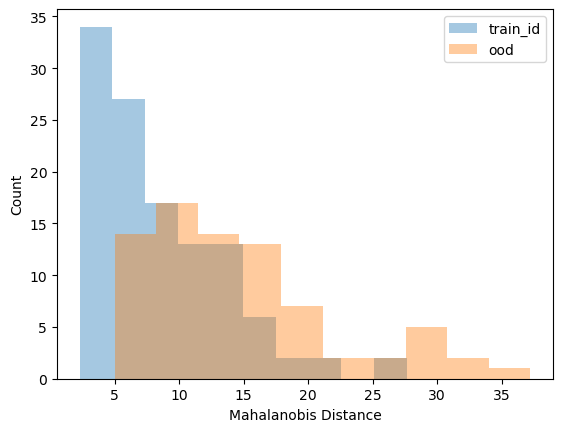

In [10]:
plt.figure()
plt.hist(df_dist_train[df_dist_train['dsource']=="train_id"].dist_l64, alpha=.4, label='train_id')
plt.hist(df_dist_train[df_dist_train['dsource']=="ood"].dist_l64, alpha=.4, label='ood')
plt.legend()
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Count")

In [11]:
from sklearn.linear_model import LogisticRegression
df_dist_train['Y']=pd.Series([0 for x in range(len(df_dist_train.index))])
df_dist_train.loc[df_dist_train['dsource']=="ood",'Y'] = pd.Series(
    [1 for x in range(np.sum(df_dist_train['dsource']=="ood"))])
clf = LogisticRegression(random_state=0).fit(
    df_dist_train.loc[:,['dist_l3','dist_l64','dist_l128']],
    df_dist_train.loc[:,"Y"])

0.9889162561576355


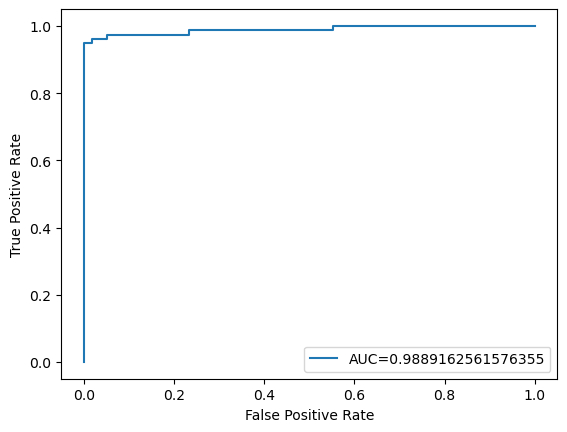

In [12]:
from sklearn import metrics

y_pred_proba = clf.predict_proba(df_dist_train.loc[:,['dist_l3','dist_l64','dist_l128']])[::,1]
fpr, tpr, _ = metrics.roc_curve(df_dist_train.loc[:,'Y'],  y_pred_proba)

auc = metrics.roc_auc_score(df_dist_train.loc[:,'Y'], y_pred_proba)
print(auc)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix
vec_pre = clf.predict(df_dist_train.loc[:,['dist_l3','dist_l64','dist_l128']])
confusion_matrix(df_dist_train.loc[:,'Y'], vec_pre)

array([[115,   1],
       [  4,  73]], dtype=int64)